In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

from dataset import *
from model import get_Model
from learning import *
from inference import *

torch.__version__

'1.11.0'

In [24]:
def label2int(data, label_tags):
    for i in range(len(data)):
        data.iloc[i,1] = label_tags.index(data.iloc[i, 1])
    return data


def draw_history(history):
    train_loss = history["train_loss"]
    train_acc = history["train_acc"]
    valid_loss = history["valid_loss"]
    valid_acc = history["valid_acc"]

    plt.subplot(2,1,1)
    plt.title("Loss")
    plt.plot(train_loss, label="train")
    plt.plot(valid_loss, label="valid")
    plt.legend()

    plt.subplot(2,1,2)
    plt.title('Accuracy')
    plt.plot(train_acc, label="train")
    plt.plot(valid_acc, label="valid")
    plt.legend()

    plt.show()
    
def get_cluster(model, device, loader, tsne):
    results = []
    labels = []

    model.to(device); model.eval()
    with torch.no_grad():
        for img, _, _, label in loader:
            img = img.to(device)
            _, embed = model(img)
            results.append(embed.cpu().numpy())
            labels.append(label)
    results = np.concatenate(results)
    _, labels = torch.max(torch.tensor(np.concatenate(labels)), dim=-1)
    labels = labels.numpy()

    embed_2d = tsne.fit_transform(results)
    
    return embed_2d, labels


def draw_cluster(model_path, device, bert_loader, roberta_loader, title, plt_shape=(2,6)):
    label_tags = ['Hat', 'Snare', 'Kick', 'Clap', 'Cymbals']
    r, c, idx = plt_shape[0], plt_shape[1], 1
    
    plt.figure(figsize=(30,12), facecolor='azure')
    for y in range(r):
        for x in range(c):
            tsne = TSNE(n_components=2, learning_rate='auto', init='random')
            
            model = torch.load(f"models/"+model_path[y][x])
            loader = bert_loader if 'BERT' in model_path[y][x] else robert_loader

            embed_2d, labels = get_cluster(model, device, loader, tsne)
            
            plt.subplot(r,c,idx)
            for label in np.unique(labels):
                tmp = embed_2d[labels==label]
                plt.scatter(tmp[:,0], tmp[:,1], label=label_tags[label])
            plt.title(title[y][x])
            plt.legend()
            idx += 1
            
    plt.savefig('Check_cluster.png')
    plt.show()

In [10]:
model = torch.load('models/MyModel_2.pt')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_path = "test.csv"
test_df = pd.read_csv(test_path)
test_dataset = MyDataset_triplet(test_df)
test_loader = DataLoader(test_dataset, batch_size=32)

In [17]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random')
embed_2d, labels = get_cluster(model, device, test_loader, tsne)

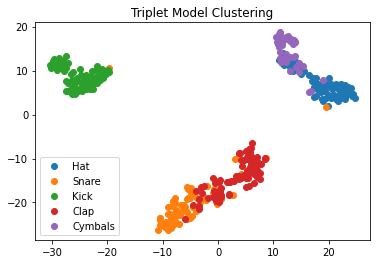

In [22]:
label_tags = ['Hat', 'Snare', 'Kick', 'Clap', 'Cymbals']
for label in np.unique(labels):
    tmp = embed_2d[labels==label]
    plt.scatter(tmp[:,0], tmp[:,1], label=label_tags[label])
    
plt.title('Triplet Model Clustering')
plt.legend()
plt.show()